# Compare predictions
Compute the jaccard index of the top k predictions 
- across all networks for a given alg
- across all algs for a given network


In [1]:
# the rest of the imports require the location to be the base of the repo 
#   i.e., SARS-CoV-2-network-analysis)
# run this first if needed to get to the right directory
import os
os.chdir('../../')
# os.chdir('/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis')
os.getcwd()

'/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis-branch'

In [3]:
from collections import defaultdict
import argparse
import os, sys
from tqdm import tqdm
import itertools
#import utils.file_utils as utils
# also compute the significance of sinksource vs local
#from scipy.stats import kruskal, mannwhitneyu
# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))
# make this the default for now
sns.set_style('darkgrid')
# my local imports
# fss_dir = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
# sys.path.insert(0,fss_dir)
from src.annotation_prediction.src import main as run_eval_algs
from src.annotation_prediction.src.plot import plot_utils
from src.annotation_prediction.src.algorithms import runner
from src.annotation_prediction.src.algorithms import alg_utils
from src.annotation_prediction.src.utils import config_utils
from src.annotation_prediction.src.evaluate import cross_validation as cv

%matplotlib inline  

python version: 3.7.7 (default, Mar 13 2020, 13:32:22) 
matplotlib version: 3.2.1
seaborn version: 0.10.0
pandas version: 1.0.3
numpy version: 1.18.2


In [4]:
def load_all_pred(input_settings, output_dir, alg_settings, use_alg_plot_name=True, k=100, **kwargs):
#     df_all = pd.DataFrame()
    order = []
    dataset_alg_prots = defaultdict(dict)
    # read in the predictions, and test for the statistical significance of overlap 
    for dataset in input_settings['datasets']:
        print("Loading data for %s" % (dataset['net_version']))
        base_out_dir = "%s/enrichment/%s/%s" % (output_dir, dataset['net_version'], dataset['exp_name'])
        # load the network and the positive examples for each term
        net_obj, ann_obj, eval_ann_obj = run_eval_algs.setup_dataset(
            dataset, input_settings['input_dir'], **kwargs)
        prots = net_obj.nodes
        prot_universe = set(prots)
        print("\t%d prots in universe" % (len(prot_universe)))
        # TODO using this for the SARS-CoV-2 project,
        # but this should really be a general purpose script
        # and to work on any number of terms 
        orig_pos_idx, _ = alg_utils.get_term_pos_neg(ann_obj.ann_matrix, 0)
        orig_pos = [prots[p] for p in orig_pos_idx]

#         # now load the predictions, test at the various k values, and TODO plot
#         k_to_test = enrichment.get_k_to_test(dataset, **kwargs)
#         print("\ttesting %d k value(s): %s" % (len(k_to_test), ", ".join([str(k) for k in k_to_test])))

        # now load the prediction scores
        dataset_name = config_utils.get_dataset_name(dataset)
        alg_pred_files = config_utils.get_dataset_alg_prediction_files(
            output_dir, dataset, alg_settings, use_alg_plot_name=not use_alg_plot_name, **kwargs)
        for alg, pred_file in alg_pred_files.items():
            if use_alg_plot_name:
                alg = plot_utils.ALG_NAMES.get(alg,alg)
            if not os.path.isfile(pred_file):
                print("Warning: %s not found. skipping" % (pred_file))
                continue
            print("reading: %s" % (pred_file))
            df = pd.read_csv(pred_file, sep='\t')
            # remove the original positives
            df = df[~df['prot'].isin(orig_pos)]
            df.reset_index(inplace=True, drop=True)
            topk_predictions = list(df.iloc[:k]['prot'])
            # UPDATE: Also load the node score pvals, and keep only the nodes with a pval < 0.05
            pval_file = pred_file.replace('outputs/','outputs/viz') \
                                 .replace('.txt','-1000rand-10kmeans-pvals.tsv')
            print("reading pvals from: %s" % (pval_file))
            df_pval = pd.read_csv(pval_file, sep='\t', index_col=0)
            df_pval = df_pval[df_pval['pval'] < 0.05]
            print("\t%d prots with pval < 0.05" % (len(df_pval)))
            df = df[df['prot'].isin(df_pval.index)]
            print("%d of the top %s prots have pval < 0.05" % (len(set(topk_predictions) & set(df_pval.index)), k))
            
            df.reset_index(inplace=True, drop=True)
            #df = df[['prot', 'score']]
            df.sort_values(by='score', ascending=False, inplace=True)
            if k is not None:
                topk_predictions = list(df.iloc[:k]['prot'])
                dataset_alg_prots[dataset_name][alg] = topk_predictions
            else:
                dataset_alg_prots[dataset_name][alg] = df
#             order.append(dataset_name)
            order.append(alg)
    return dataset_alg_prots, order

In [85]:
config_files = [
#     "fss_inputs/config_files/combined/string-tissuenet-lung.yaml",
    "ann_pred_inputs/config_files/stringv11/string-combined-and-deepnf.yaml",
#     "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml",
]
neg_factor = 5
# k_to_test = [100,200,300]
k_to_test = [1000]

In [86]:
# manually change the order of the heatmap to match the clustergrid output
# algs = ['localplus', 'rl', 'rwr', 'sinksourceplus', 'deepnf', 'svm', 'logistic_regression', 'genemania']
algs = ['rl', 'rwr', 'sinksourceplus', 'deepnf', 'svm', 'localplus', 'logistic_regression', 'genemania']

In [87]:
k_results = []
for k in k_to_test:
    all_dataset_prots = {}
    order = []
    for config_file in config_files:
        print(config_file)
        config_map = plot_utils.load_config_file(config_file)
        kwargs = {}
        input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
                config_map, '', **kwargs)
        # set additional options here
        kwargs['algs'] = algs
        kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
        kwargs['cross_validation_folds'] = 5
        kwargs['cv_seed'] = None
        kwargs['sample_neg_examples_factor'] = neg_factor
        print(kwargs)

        dataset_alg_prots, curr_order = load_all_pred(input_settings, output_settings['output_dir'], alg_settings, k=k, **kwargs)
        all_dataset_prots.update(dataset_alg_prots)
        order += curr_order
        print("%d datasets" % (len(dataset_alg_prots)))
        print(order)
    #     title = set_title(**kwargs)
    #     print(title)
    #     order = pointplot(df_all, out_file=out_file, order=order)
    k_results.append(dataset_alg_prots)
order = order[:len(algs)]

ann_pred_inputs/config_files/stringv11/string-combined-and-deepnf.yaml
{'num_pred_to_write': -1, 'num_reps': 100, 'sample_neg_examples_factor': 5, 'postfix': '', 'algs': ['rl', 'rwr', 'sinksourceplus', 'deepnf', 'svm', 'localplus', 'logistic_regression', 'genemania'], 'cross_validation_folds': 5, 'cv_seed': None}
Loading data for networks/stringv11/400
	reading sparse nets from ann_pred_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from ann_pred_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from ann_pred_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from ann_pred_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components

In [88]:
# manually change the order of the heatmap to match the clustergrid output
order = ['RL', 'RWR', 'SS', 'deepNF', 'SVM', 'Local', 'LogReg', 'GM']

In [89]:
def overlap_heatmap(alg_prots, order, k, ax=None, annot=False, out_file=None, square=False, verbose=False):
    # compute the ovlerap between each algorithm
    overlaps = defaultdict(dict)
    for i, (a1, prots1) in enumerate(sorted(alg_prots.items())):
        for j, (a2, prots2) in enumerate(sorted(alg_prots.items())):
            if j == i: 
                overlaps[a1][a2] = 1
                continue
            # intersection / union
#             print(d1, d2, len(set(prots1) & set(prots2)))
            jaccard_index = len(set(prots1) & set(prots2)) / float(len(set(prots1) | set(prots2)))
            overlaps[a1][a2] = jaccard_index
    df = pd.DataFrame(overlaps)
    print(df.head())
    df = df[order]
    df = df.T[order].T
    if verbose:
        print(df.head())
    # now make a heatmap of all the datasets
#     f, ax = plt.subplots(figsize=(18,28))
    cbar = True if k == k_to_test[-1] else False
    if annot:
        ax = sns.heatmap(data=(df*100).astype(int), cmap="YlGnBu", cbar=cbar, annot=True, fmt='d', square=square, ax=ax)
    else:
        ax = sns.heatmap(data=df, cmap="YlGnBu", cbar=cbar, square=square, ax=ax)
    ax.set_title("k = %s" % (k))
    if out_file is not None:
        out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
        print(out_file)
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
    #     plt.savefig(out_file, bbox_inches='tight')
        # plt.savefig(out_file.replace('.pdf','.png'), bbox_inches='tight')
        # also write the values to a file
    #     df.to_csv(out_file.replace('.pdf','.csv'))
    return df, ax

dict_keys(['STRING-400', 'STRING-all-400'])
STRING-400
STRING-all-400
              GM     Local    LogReg        RL       RWR        SS       SVM  \
GM      1.000000  0.033091  0.023020  0.030363  0.029005  0.026974  0.026298   
Local   0.033091  1.000000  0.039571  0.232286  0.226994  0.201923  0.122334   
LogReg  0.023020  0.039571  1.000000  0.045884  0.046590  0.045179  0.049425   
RL      0.030363  0.232286  0.045884  1.000000  0.683502  0.450326  0.296176   
RWR     0.029005  0.226994  0.046590  0.683502  1.000000  0.562500  0.317523   

          deepNF  
GM      0.028327  
Local   0.091107  
LogReg  0.040268  
RL      0.217285  
RWR     0.249219  
outputs/viz/networks/overlap/STRING-all-400-8algs-jaccard.pdf


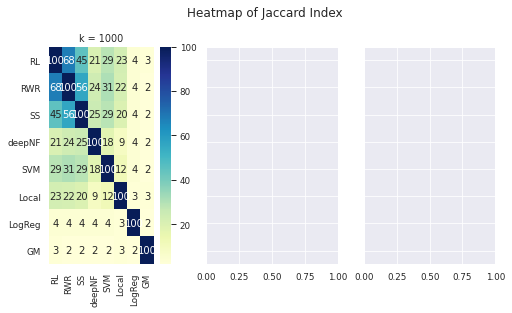

In [90]:
annot = True
datasets = k_results[0].keys()
print(datasets)
# UPDATE: deepnf is in a different dataset, so combine it here
k_alg_prots = defaultdict(dict)
for dataset in datasets:
    print(dataset)
    for i, dataset_alg_prots in enumerate(k_results):
        k = k_to_test[i]
        alg_prots = dataset_alg_prots[dataset]
        k_alg_prots[k].update(alg_prots)
        
f, axes = plt.subplots(ncols=3, sharey=True, figsize=(8,4))
for i, (k, alg_prots) in enumerate(k_alg_prots.items()):
    ax = axes[i]
        
#         ax = overlap_heatmap(alg_prots, order, k, ax=ax)
    df, ax = overlap_heatmap(alg_prots, order, k, ax=ax, annot=annot)
    
    
alg_str = '-'.join(algs) if len(algs) <= 3 else "%dalgs" % (len(algs))
plt.suptitle("Heatmap of Jaccard Index", y=1.02)
out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
print(out_file)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
if annot:
    plt.savefig(out_file.replace('.pdf','-ann.svg'), bbox_inches='tight')
else:
    plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
plt.show()
plt.close()

In [81]:
# check how many proteins were in common between RL and RWR
alg_prots = k_results[2]['STRING-400']
print(len(set(alg_prots['RL']) & set(alg_prots['RWR'])))
print(len(set(alg_prots['RL']) | set(alg_prots['RWR'])))

189
411


In [91]:
# check how many proteins were in common between RL and RWR
alg_prots = k_results[0]['STRING-400']
print(len(set(alg_prots['RL']) & set(alg_prots['RWR'])))
print(len(set(alg_prots['RL']) | set(alg_prots['RWR'])))

812
1188


In [82]:
# check how many proteins were in common between RL and RWR
alg_prots = k_results[2]['STRING-400']
print(len(set(alg_prots['SVM']) & set(alg_prots['RWR'])))
print(len(set(alg_prots['SVM']) | set(alg_prots['RWR'])))

167
433


In [83]:
# check how many proteins were in common between RL and RWR
alg_prots = k_results[2]['STRING-400']
print(len(set(alg_prots['SS']) & set(alg_prots['RWR'])))
print(len(set(alg_prots['SS']) | set(alg_prots['RWR'])))

157
443


In [84]:
# check how many proteins were in common between RL and RWR
alg_prots = k_results[2]['STRING-400']
print(len(set(alg_prots['RL']) & set(alg_prots['SVM'])))
print(len(set(alg_prots['RL']) | set(alg_prots['SVM'])))

108
492


# Compare parameters of a single method


In [54]:
def plot_dataset_k_results(k_results, algs, write_out_file=True):
    datasets = k_results[0].keys()
    for dataset in datasets:
        f, axes = plt.subplots(ncols=len(k_results), sharey=True)
        for i, dataset_alg_prots in enumerate(k_results):
            k = k_to_test[i]
            ax = axes[i]
            alg_prots = dataset_alg_prots[dataset]
            overlap_heatmap(alg_prots, order, k, ax=ax)

        alg_str = '-'.join(algs) if len(algs) <= 3 else "%dalgs" % (len(algs))
        plt.suptitle("Heatmap of Jaccard Index for %s" % (dataset), y=1.02)
        if write_out_file:
            out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
            print(out_file)
            os.makedirs(os.path.dirname(out_file), exist_ok=True)
            plt.savefig(out_file, bbox_inches='tight')
            plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
        plt.show()
        plt.close()

In [49]:
config_files = [
#     "fss_inputs/config_files/combined/string-tissuenet-lung.yaml",
#     "fss_inputs/config_files/string-tissuenet-wace2/string.yaml",
    "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml",
]
neg_factor = 5
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus']
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression']
algs = ['genemaniaplus']
k_to_test = [332,1000]

fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml
{'cross_validation_folds': 5, 'num_pred_to_write': -1, 'num_reps': 100, 'sample_neg_examples_factor': 5, 'palette': 'Set2', 'svg': True, 'postfix': '', 'algs': ['genemaniaplus'], 'cv_seed': None}
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (100.00%) pos prots are in the largest cc
	18886 p

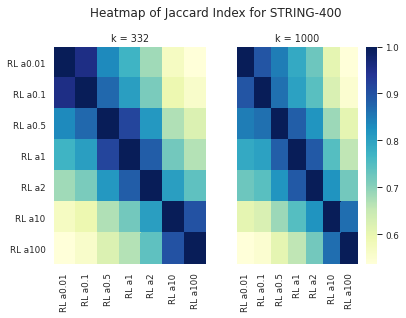

In [55]:
rename_alg_params = {
    "-tol1e-05":"", "-tol1e-04":"", "-rep100-nf5":"","-l2":"", "-maxi1000":"","-maxi100":"", "-eps0": "",
    "-a": " a", "-C":" C", "-l":" l", "_": "."}
for alg in algs:
    k_results = []
    for k in k_to_test:
        all_dataset_prots = {}
        order = []
        for config_file in config_files:
            print(config_file)
            config_map = plot_utils.load_config_file(config_file)
            kwargs = {}
            input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
                    config_map, '', **kwargs)
            # set additional options here
            kwargs['algs'] = [alg]
            kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
            kwargs['cross_validation_folds'] = 5
            kwargs['cv_seed'] = None
            kwargs['sample_neg_examples_factor'] = neg_factor
            print(kwargs)

            dataset_alg_prots, curr_order = load_all_pred(
                input_settings, output_settings['output_dir'], alg_settings, k=k, use_alg_plot_name=False, **kwargs)
            
            # change the parameters that are included in the output string
            new_dataset_alg_prots = defaultdict(dict)
            new_curr_order = []
            for d in dataset_alg_prots:
                for curr_alg in curr_order:
                    new_alg = curr_alg
                    for p1, p2 in rename_alg_params.items():
                        new_alg = new_alg.replace(p1,p2)
                    new_dataset_alg_prots[d][new_alg] = dataset_alg_prots[d][curr_alg]
                    new_curr_order.append(new_alg)
            dataset_alg_prots = new_dataset_alg_prots
            curr_order = new_curr_order
            
            all_dataset_prots.update(dataset_alg_prots)
            order += curr_order
            print("%d datasets" % (len(dataset_alg_prots)))
            print(order)
        #     title = set_title(**kwargs)
        #     print(title)
        #     order = pointplot(df_all, out_file=out_file, order=order)
        k_results.append(dataset_alg_prots)
    order = order[:len(curr_order)]
    plot_dataset_k_results(k_results, [alg], write_out_file=True)
#     break

## Now measure the spearman's correlation of both the ranks and the scores between methods

In [17]:
from scipy.stats import spearmanr

In [18]:
# manually change the order of the heatmap to match the clustergrid output
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus']
algs = ['localplus', 'rl', 'rwr', 'sinksourceplus', 'svm', 'deepnf', 'logistic_regression', 'genemania']

In [43]:
for config_file in config_files:
    print(config_file)
    config_map = plot_utils.load_config_file(config_file)
    kwargs = {}
    input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
            config_map, '', **kwargs)
    # set additional options here
    kwargs['algs'] = algs
    kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
    kwargs['sample_neg_examples_factor'] = neg_factor

    df_all = load_all_pred_scores(
        input_settings, output_settings['output_dir'], alg_settings, k=None, use_alg_plot_name=True, **kwargs)

ann_pred_inputs/config_files/stringv11/string-combined-and-deepnf.yaml
Loading data for networks/stringv11/400
	reading sparse nets from ann_pred_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from ann_pred_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from ann_pred_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from ann_pred_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (100.00%) pos prots are in the largest cc
	18886 prots in universe
reading: outputs//networks/stringv11/400/2020-03-sarscov2-human-ppi-ace2//localplus/pred-scores-l0.txt
reading: outputs//networks/stringv11/400/2020-03-sar

In [44]:
def pred_score_spearman(df_all, order=None, verbose=False):
    df = df_all.reset_index()
    df.rename(columns={'index': 'Rank', 'score': 'Score'}, inplace=True)
    df = df.pivot(index="prot", columns="Algorithm", values="Score")
    # compute the spearman correlation between each dataset
    overlaps = defaultdict(dict)
    if order is None:
        order = df_all['Algorithm'].unique()
        print(order)
    for i, a1 in enumerate(order):
        for j, a2 in enumerate(order):
#             if i >= j:
#                 continue
            if i == j:
                overlaps[a1][a2] = 1
                continue
            curr_df = df.sort_values(a1, ascending=False)[[a1, a2]].dropna()
    #         df2.sort_values('Score', ascending=False, inplace=True)
    #         print(curr_df.head())
    #         print(df2.head())
            correlation, pvalue = spearmanr(curr_df[a1], curr_df[a2])
#             print(a1, a2, correlation, pvalue, len(curr_df))
            overlaps[a1][a2] = correlation
    df = pd.DataFrame(overlaps)
#     print(df.head())
    df = df[order]
    df = df.T[order].T
    if verbose:
        print(df.head())
    return df
df = pred_score_spearman(df_all)
df.head()

['Local' 'RL' 'RWR' 'SS' 'SVM' 'LogReg' 'GM' 'deepNF']


,Local,RL,RWR,SS,SVM,LogReg,GM,deepNF
Local,1.000000,0.566331,0.643700,0.212970,0.309546,0.089051,0.067152,0.285314
RL,0.566331,1.000000,0.945829,0.772185,0.566513,0.146528,0.081119,0.543594
RWR,0.643700,0.945829,1.000000,0.871996,0.502244,0.135622,0.087169,0.517140
SS,0.212970,0.772185,0.871996,1.000000,0.413226,0.117194,0.072003,0.458155
SVM,0.309546,0.566513,0.502244,0.413226,1.000000,0.139545,0.044406,0.404246


['Local' 'RL' 'RWR' 'SS' 'SVM' 'LogReg' 'GM' 'deepNF']


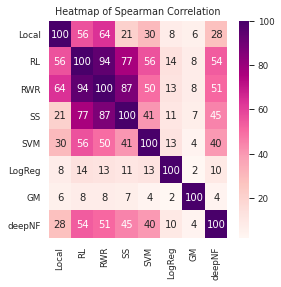

In [45]:
def plot_heatmap(df, ax=None, out_file=None, dataset="STRING-400", annot=False):
    # now make a heatmap of all the datasets
    if ax is None:
#         f, ax = plt.subplots(figsize=(6,6))
        f, ax = plt.subplots(figsize=(4,4))
#     cbar = True if k == k_to_test[-1] else False
    if annot:
        ax = sns.heatmap(data=(df*100).astype(int), cmap="RdPu", annot=True, fmt='d', ax=ax)
    else:
        ax = sns.heatmap(data=df, cmap="RdPu", ax=ax)
#     ax.set_title("STRING - Spearman Correlation")
    ax.set_title("Heatmap of Spearman Correlation")
    plt.yticks(rotation=0)
    if out_file is not None:
        alg_str = "%dalgs" % (len(df.columns))
        if annot:
            out_file = "outputs/viz/networks/overlap/%s-%s-spearman-annot.pdf" % (dataset, alg_str)
        else:
            out_file = "outputs/viz/networks/overlap/%s-%s-spearman.pdf" % (dataset, alg_str)
        print(out_file)
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
        plt.savefig(out_file, bbox_inches='tight')
        plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
        # also write the values to a file
        df.to_csv(out_file.replace('.pdf','.csv'))
    return ax
df = pred_score_spearman(df_all)
ax = plot_heatmap(df, annot=True)

outputs/viz/networks/overlap/STRING-400-8algs-spearman-annot.pdf


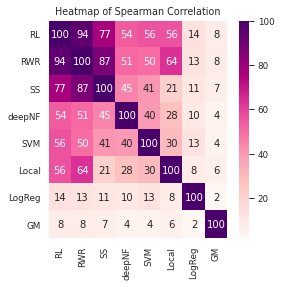

In [58]:
df = pred_score_spearman(df_all, order=['RL', 'RWR', 'SS', 'deepNF', 'SVM', 'Local', 'LogReg', 'GM'])
# ax = plot_heatmap(df, out_file=True, annot=True)
ax = plot_heatmap(df, out_file=True, annot=True)
# ax = plot_heatmap(df)


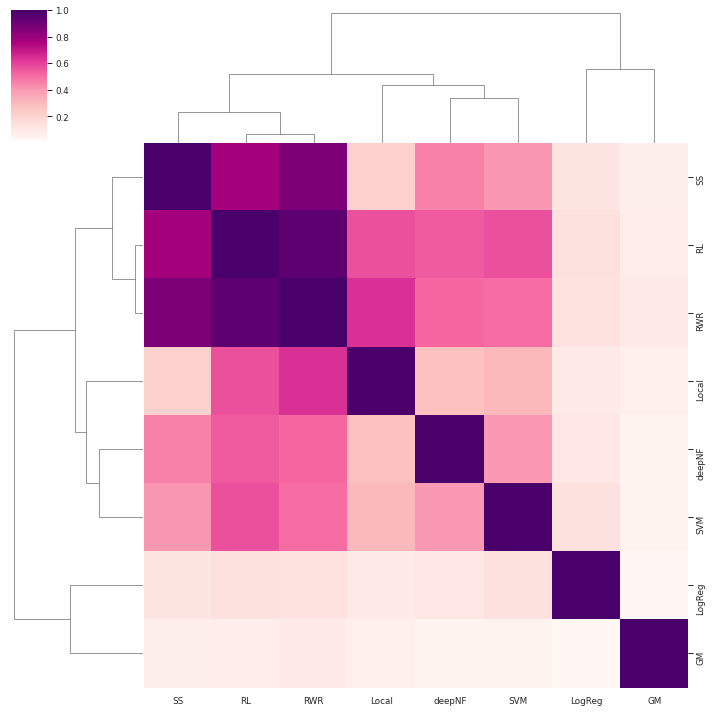

In [54]:
sns.clustermap(data=df, method="ward", cmap="RdPu")
# ax = sns.heatmap(data=df, cmap="YlGnBu", ax=ax)
#     ax.set_title("STRING - Spearman Correlation")

In [226]:
for i, (a1, df1) in enumerate(df.groupby("Algorithm")):
    for j, (a2, df2) in enumerate(df.groupby("Algorithm")):
        if i <= j:
            continue
        df1.sort_values('Score', ascending=False, inplace=True)
        df2.sort_values('Score', ascending=False, inplace=True)
        print(df1.head())
        print(df2.head())
        correlation, pvalue = spearmanr(df1['Rank'], df2['Rank'])
        print(a1, a2, correlation, pvalue)

KeyError: 'Algorithm'

# Plot the prediction scores

In [83]:
sns.set_style("whitegrid")

In [146]:
config_files = [
#     "fss_inputs/config_files/combined/string-tissuenet-lung.yaml",
    "fss_inputs/config_files/string-tissuenet-wace2/string.yaml",
#     "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml",
]
neg_factor = 5
# algs = ['genemaniaplus']
algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus']
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression']
k_to_test = [100,200,300]

In [21]:
def load_all_pred_scores(input_settings, output_dir, alg_settings, use_alg_plot_name=True, k=100, **kwargs):
#     df_all = pd.DataFrame()
    order = []
#     dataset_alg_prots = defaultdict(dict)
    df_all = pd.DataFrame()
    # read in the predictions, and test for the statistical significance of overlap 
    for dataset in input_settings['datasets']:
        print("Loading data for %s" % (dataset['net_version']))
        base_out_dir = "%s/enrichment/%s/%s" % (output_dir, dataset['net_version'], dataset['exp_name'])
        # load the network and the positive examples for each term
        net_obj, ann_obj, eval_ann_obj = run_eval_algs.setup_dataset(
            dataset, input_settings['input_dir'], **kwargs)
        prots = net_obj.nodes
        prot_universe = set(prots)
        print("\t%d prots in universe" % (len(prot_universe)))
        # TODO using this for the SARS-CoV-2 project,
        # but this should really be a general purpose script
        # and to work on any number of terms 
        orig_pos_idx, _ = alg_utils.get_term_pos_neg(ann_obj.ann_matrix, 0)
        orig_pos = [prots[p] for p in orig_pos_idx]

#         # now load the predictions, test at the various k values, and TODO plot
#         k_to_test = enrichment.get_k_to_test(dataset, **kwargs)
#         print("\ttesting %d k value(s): %s" % (len(k_to_test), ", ".join([str(k) for k in k_to_test])))

        # now load the prediction scores
        dataset_name = config_utils.get_dataset_name(dataset)
        alg_pred_files = config_utils.get_dataset_alg_prediction_files(
            output_dir, dataset, alg_settings, use_alg_plot_name=not use_alg_plot_name, **kwargs)
        for alg, pred_file in alg_pred_files.items():
            if use_alg_plot_name:
                alg = plot_utils.ALG_NAMES.get(alg,alg)
            if not os.path.isfile(pred_file):
                print("Warning: %s not found. skipping" % (pred_file))
                continue
            print("reading: %s" % (pred_file))
            df = pd.read_csv(pred_file, sep='\t')
            # remove the original positives
            df = df[~df['prot'].isin(orig_pos)]
            df.reset_index(inplace=True, drop=True)
            #df = df[['prot', 'score']]
            df.sort_values(by='score', ascending=False, inplace=True)
            if k is not None:
                df = df.iloc[:k]
#                 dataset_alg_prots[dataset_name][alg] = topk_predictions
#             else:
#                 dataset_alg_prots[dataset_name][alg] = df
            df['Algorithm'] = alg
#             if alg in ['GM', 'SVM']:
#                 # flip the score to plot them
#                 # TODO make my own bar plot with fill_between(?)
#                 df['score'] = df['score'] - (df['score'].min()*2)
# #                 a = -df['score'].max()
# #                 b = -df['score'].min()
# #                 df['score'] = (b-a)*((df['score'] - -a)/float(-b - -a)) + a
            df_all = pd.concat([df_all, df])
#             order.append(dataset_name)
            order.append(alg)
    return df_all

In [222]:
all_dataset_prots = {}
order = []
for config_file in config_files:
    print(config_file)
    config_map = plot_utils.load_config_file(config_file)
    kwargs = {}
    input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
            config_map, '', **kwargs)
    # set additional options here
    kwargs['algs'] = algs
    kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
    kwargs['cross_validation_folds'] = 5
    kwargs['cv_seed'] = None
    kwargs['sample_neg_examples_factor'] = neg_factor
    print(kwargs)

    df_all = load_all_pred_scores(
#         input_settings, output_settings['output_dir'], alg_settings, k=500, use_alg_plot_name=True, **kwargs)
        input_settings, output_settings['output_dir'], alg_settings, k=None, use_alg_plot_name=True, **kwargs)

#     all_dataset_prots.update(dataset_alg_prots)
#     order += curr_order
#     print("%d datasets" % (len(dataset_alg_prots)))
#     print(order)

#     order = order[:len(curr_order)]
#     plot_dataset_k_results(k_results, [alg], write_out_file=True)
#     for d, alg_prots in dataset_alg_prots.items():    
#     plot_pred_scores(df_all)
    break

fss_inputs/config_files/string-tissuenet-wace2/string.yaml
{'num_pred_to_write': -1, 'num_reps': 100, 'sample_neg_examples_factor': 5, 'postfix': '', 'algs': ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus'], 'cross_validation_folds': 5, 'cv_seed': None}
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (1

In [198]:
df = df_all.reset_index()
df['index'] += 1
df.rename(columns={'index': 'Rank', 'score': 'Score'}, inplace=True)
df.head()

,Rank,#term,prot,Score,Algorithm
0,1,2020-03-sarscov2-human-ppi,Q8NBI6,0.001576,GM+
1,2,2020-03-sarscov2-human-ppi,Q969Z3,0.001525,GM+
2,3,2020-03-sarscov2-human-ppi,Q9BVV7,0.001474,GM+
3,4,2020-03-sarscov2-human-ppi,Q9NY35,0.001440,GM+
4,5,2020-03-sarscov2-human-ppi,Q9GZP9,0.001401,GM+


outputs/viz/networks/stringv11/400/2020-03-sarscov2-human-ppi-ace2/pred-scores.pdf


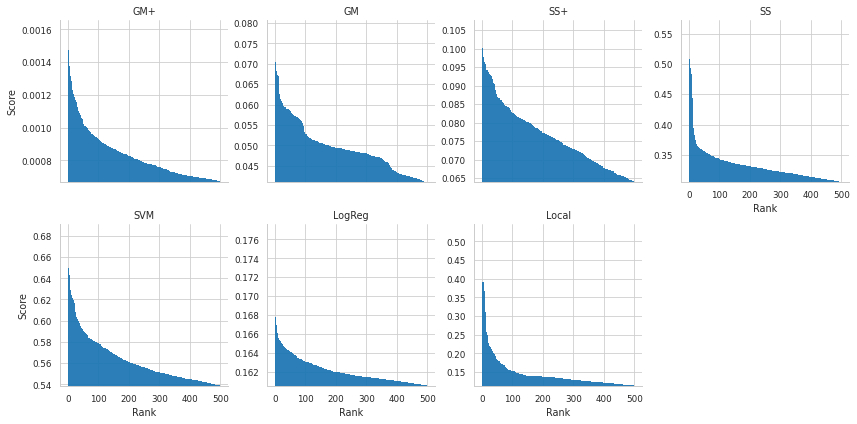

In [202]:
g = sns.FacetGrid(df, col='Algorithm', col_wrap=4, sharey=False)
g = g.map(plt.bar, "Rank", "Score", width=1, linewidth=0, alpha=0.95).set_titles('{col_name}')
for i, ax in enumerate(g.axes.flat):
    ax.set_ylim(df[df['Algorithm'] == ax.get_title()]['Score'].min(), ax.get_ylim()[1])
    
# plt.suptitle()
    
out_file = "outputs/viz/networks/stringv11/400/2020-03-sarscov2-human-ppi-ace2/pred-scores.pdf"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.pdf','.png'), bbox_inches='tight')